# Project 3: Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

When finished, you can close the environment.

### External Dependencies

In [2]:
import numpy as np
import logging
import os
import pandas as pd
from pathlib import Path
import torch
import torch.nn.functional as F

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

### Internal Dependencies
As described in the report and as in the previous project, we are using a custom library called rl_library which needs to be installed AFTER the unityagents as been setup.

For this execute the following steps from a terminal in the correct virtual environment at the root of the repository:


 - `pip install -r requirements.txt`
 - `pip install . `


In [3]:
from unityagents import UnityEnvironment
from rl_library.agents.maddpg_agent import MADDPGAgent
from rl_library.agents.models.bodies import SimpleNeuralNetBody
from rl_library.agents.models.heads import SimpleNeuralNetHead, DeepNeuralNetHeadCritic
from rl_library.monitors.unity_monitor import UnityMonitor

### Logger

In [4]:
save_path = f"./results/Tennis_MADDPG_{pd.Timestamp.utcnow().value}"
os.makedirs(save_path, exist_ok=True)

logger = logging.getLogger()
logger.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s : %(message)s')

handler = logging.FileHandler(f"{save_path}/logs_p3_{pd.Timestamp.utcnow().value}.log")
handler.setLevel(logging.DEBUG)
handler.setFormatter(formatter)
logger.addHandler(handler)

### Configuration

In [5]:
n_episodes = 3000
config = dict(
    # Environment parameters
    env_name="Tennis",
    n_episodes=n_episodes,
    length_episode=1500,
    save_every=500,
    save_path=save_path,
    mode="train",  # "train" or "test"
    evaluate_every=5000,  # Number of training episodes before 1 evaluation episode
    eps_decay=1,  # Epsilon decay rate

    # Agent Parameters
    agent="DDPG",
    hidden_layers_actor=(256, 128),  # (50, 50, 15),  # (200, 150),  #
    hidden_layers_critic_body=(256,),  # (50, 50,),  #
    hidden_layers_critic_head=(128,),  # (50,),   # (300,)
    func_critic_body="F.leaky_relu",  #
    func_critic_head="F.leaky_relu",  #
    func_actor_body="F.leaky_relu",  #
    lr_scheduler={'scheduler_type': "exp", #. "multistep",  # "step",  or "decay", "multistep"
                   'gamma': 0.999999,  #  0.75, 
                   'step_size': 1,
    #               'milestones': [30 * 1000 * i for i in range(1, 6)],
                   'max_epochs': n_episodes},

    TAU=1e-3,  # for soft update of target parameters
    BUFFER_SIZE=int(3e4),  # replay buffer size
    BATCH_SIZE=128,  # minibatch size
    GAMMA=0.99,  # discount factor
    LR_ACTOR=1e-4,  # learning rate of the actor
    LR_CRITIC=1e-4,  # learning rate of the critic
    WEIGHT_DECAY=0,  # L2 weight decay
    UPDATE_EVERY=1,  # Number of actions before making a learning step
    N_CONSECUTIVE_LEARNING_STEPS=2,
    action_noise="OU",  #
    action_noise_scale=1,
    weights_noise=None,  #
    state_normalizer="BatchNorm",  # "RunningMeanStd" or "BatchNorm"
    warmup=1e3,  # Number of random actions to start with as a warm-up
    start_time=str(pd.Timestamp.utcnow()),
    random_seed=seed,
    threshold=0.5
)

## 1. Initialization

### 1. Start the Environment

In [6]:
env = UnityEnvironment(file_name=f'./{config["env_name"]}')  # mac OS

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [7]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)
config["n_agents"] = num_agents

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
config.update(dict(action_size=action_size, state_size=state_size))

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


##  2. Training

### Unity Monitor

In [8]:
monitor = UnityMonitor(env=env, config=config)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -7.38993645 -1.5
 -0.          0.          6.83172083  5.99607611 -0.          0.        ]


### Actor and Critic models

In [9]:
# Actor model
seed = 0
actor = SimpleNeuralNetHead(action_size,
                            SimpleNeuralNetBody(state_size, config["hidden_layers_actor"], seed=seed),
                            func=torch.tanh, seed=seed)
# Critic model
critic = DeepNeuralNetHeadCritic(action_size*num_agents,
                                 SimpleNeuralNetBody(state_size*num_agents, config["hidden_layers_critic_body"],
                                                     func=eval(config["func_critic_body"]), seed=seed),
                                 hidden_layers_sizes=config["hidden_layers_critic_head"],
                                 func=eval(config["func_critic_head"]),
                                 end_func=None, seed=seed)

INFO:rllib.models:Initialized SimpleNeuralNetHead with body : ModuleList(
  (0): Linear(in_features=24, out_features=256, bias=True)
  (1): Linear(in_features=256, out_features=128, bias=True)
) and head Linear(in_features=128, out_features=2, bias=True)
INFO:rllib.models:Initialized DeepNeuralNetHeadCritic with body : ModuleList(
  (0): Linear(in_features=48, out_features=256, bias=True)
) and head ModuleList(
  (0): Linear(in_features=260, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=1, bias=True)
)


### DDPG Agent

In [10]:
agent = MADDPGAgent(state_size=state_size, action_size=action_size,
                    model_actor=actor, model_critic=critic,
                    action_space_low=-1, action_space_high=1,
                    config=config,
                    )
agent.debug_mode = False  # Current default debug_mode for agent is True, which would print out most variables 
for _agent in agent.agents: _agent.debug_mode = False
# every 10000 steps of the agent. Turning off to not overwhelm the jupyter notebook.

INFO:rllib.ddpgagent:Actor Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
INFO:rllib.ddpgagent:Critic Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
INFO:rllib.ddpgagent:Actor LR Scheduler: <torch.optim.lr_scheduler.ExponentialLR object at 0x12ddb8b00>
INFO:rllib.ddpgagent:Critic LR Scheduler: <torch.optim.lr_scheduler.ExponentialLR object at 0x12ddb8828>
INFO:rllib.ddpgagent:Initiated state_normalizer=None, reward_normalizer=None
INFO:rllib.ddpgagent:Actor Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
INFO:rllib.ddpgagent:Critic Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
INFO:rllib.ddpgagent:Actor LR Scheduler: <torch.optim.lr_scheduler.ExponentialLR

### Training

In [11]:
start = pd.Timestamp.utcnow()
scores = monitor.run(agent)
logger.info("Average Score last 100 episodes: {}".format(np.mean(scores[-100:])))
elapsed_time = pd.Timedelta(pd.Timestamp.utcnow() - start).total_seconds()
logger.info(f"Elapsed Time: {elapsed_time} seconds")

INFO:rllib.monitor:Episode 25    Average Score: 0.00e+00, Agent Loss: [0. 0.], Last Score: avg=-5.00e-03, min=-1.00e-02, max=0.00e+00 (13 steps), eps: 1.00
INFO:rllib.monitor:Episode 50    Average Score: 4.00e-03, Agent Loss: [0. 0.], Last Score: avg=-5.00e-03, min=-1.00e-02, max=0.00e+00 (13 steps), eps: 1.00
INFO:rllib.ddpgagent:End of warm up after 1000 steps.
INFO:rllib.monitor:Episode 75    Average Score: 6.53e-03, Agent Loss: [-1.24242165e-02  4.02407427e-05], Last Score: avg=-5.00e-03, min=-1.00e-02, max=0.00e+00 (13 steps), eps: 1.00
INFO:rllib.monitor:Episode 100    Average Score: 1.17e-02, Agent Loss: [-2.82357855e-02  5.55230951e-05], Last Score: avg=-5.00e-03, min=-1.00e-02, max=0.00e+00 (13 steps), eps: 1.00
INFO:rllib.monitor:MADDPG Agent: 
Agent 0:	- Actor Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0001
    lr: 9.985510500180884e-05
    weight_decay: 0
)
	- Critic Optimizer: Adam (
Parameter Group 0
   

In [12]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})
sb.despine()
sb.set_context("talk")

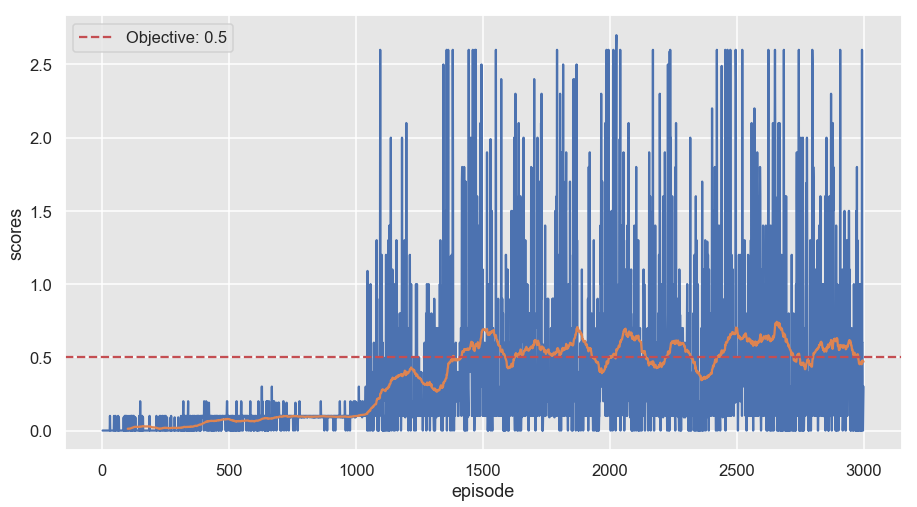

In [14]:
%matplotlib inline

df = pd.DataFrame({"scores": scores})
df["episode"] = df.index + 1
df["rolling_score_100"] = df["scores"].rolling(100).mean()

plt.figure(figsize=(15, 8))
sb.lineplot(x="episode", y="scores", data=df)
sb.lineplot(x="episode", y="rolling_score_100", data=df)
plt.axhline(0.5, c="r", ls="--", label="Objective: 0.5")
plt.legend()
plt.show()

## 3. Testing

In [15]:
import json
with open(f"./config.json", "r") as f:
    config = json.load(f)
config["mode"] = "test"
config["n_episodes"] = 10
config["warmup"] = 0

monitor = UnityMonitor(env=env, config=config)
# Actor model
seed = 0
actor = SimpleNeuralNetHead(action_size,
                            SimpleNeuralNetBody(state_size, config["hidden_layers_actor"], seed=seed),
                            func=torch.tanh, seed=seed)
# Critic model
critic = DeepNeuralNetHeadCritic(action_size*num_agents,
                                 SimpleNeuralNetBody(state_size*num_agents, config["hidden_layers_critic_body"],
                                                     func=eval(config["func_critic_body"]), seed=seed),
                                 hidden_layers_sizes=config["hidden_layers_critic_head"],
                                 func=eval(config["func_critic_head"]),
                                 end_func=None, seed=seed)

# MADDPG Agent
agent = MADDPGAgent(state_size=state_size, action_size=action_size,
                    model_actor=actor, model_critic=critic,
                    action_space_low=-1, action_space_high=1,
                    config=config,
                    )
agent.load(".", mode="test")
agent.debug_mode = False
env.reset(train_mode=False)[brain_name]
scores = monitor.run(agent)

logger.info(f"Test Score over {len(scores)} episodes: {np.mean(scores)}")

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -7.00419092 -1.5
 -0.          0.          7.77118683  5.94114017 -0.          0.        ]


INFO:rllib.models:Initialized SimpleNeuralNetHead with body : ModuleList(
  (0): Linear(in_features=24, out_features=256, bias=True)
  (1): Linear(in_features=256, out_features=128, bias=True)
) and head Linear(in_features=128, out_features=2, bias=True)
INFO:rllib.models:Initialized DeepNeuralNetHeadCritic with body : ModuleList(
  (0): Linear(in_features=48, out_features=256, bias=True)
) and head ModuleList(
  (0): Linear(in_features=260, out_features=128, bias=True)
  (1): Linear(in_features=128, out_features=1, bias=True)
)
INFO:rllib.ddpgagent:Actor Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
INFO:rllib.ddpgagent:Critic Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)
INFO:rllib.ddpgagent:Actor LR Scheduler: None
INFO:rllib.ddpgagent:Critic LR Scheduler: None
INFO:rllib.ddpgagent:Initiated state_normalizer=None, r

UnityActionException: There was a mismatch between the provided action and environment's expectation: The brain TennisBrain expected 4 continuous action(s), but was provided: [0.3528104691935328, 0.08003144167344467]

#### When finished, you can close the environment.

In [16]:
logger.info("Closing...")
env.close()

INFO:root:Closing...
